# Feature Selection for id-Features

## import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

## read data

In [2]:
identity_dataframe = pd.read_csv('data/train_identity.csv')
identity_dataframe.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [3]:
transaction_dataframe = pd.read_csv('data/train_transaction.csv')
transaction_dataframe.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
is_fraud_dataframe = transaction_dataframe[['TransactionID', 'isFraud']]
is_fraud_dataframe.head()

,TransactionID,isFraud
0,2987000,0
1,2987001,0
2,2987002,0
3,2987003,0
4,2987004,0


In [5]:
dataframe = identity_dataframe.merge(is_fraud_dataframe, on='TransactionID')
dataframe.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


## get some basic info about the data

In [6]:
dataframe.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,isFraud
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000,144233.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597,0.078470
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502,0.268911
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000,0.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000,0.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000,0.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000,1.000000


## remove irrelevant column (TransactionID)

In [7]:
dataframe = dataframe.drop('TransactionID', axis=1)
dataframe.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


## check the percentage of NaNs in each column

In [8]:
for column in dataframe.columns:
    num_nans = dataframe[column].isna().sum()
    print('percentage of NaNs for {}: {:.3f}'.format(
        column, 
        num_nans / len(dataframe) * 100
    ))

percentage of NaNs for id_01: 0.000
percentage of NaNs for id_02: 2.330
percentage of NaNs for id_03: 54.016
percentage of NaNs for id_04: 54.016
percentage of NaNs for id_05: 5.108
percentage of NaNs for id_06: 5.108
percentage of NaNs for id_07: 96.426
percentage of NaNs for id_08: 96.426
percentage of NaNs for id_09: 48.052
percentage of NaNs for id_10: 48.052
percentage of NaNs for id_11: 2.257
percentage of NaNs for id_12: 0.000
percentage of NaNs for id_13: 11.726
percentage of NaNs for id_14: 44.504
percentage of NaNs for id_15: 2.252
percentage of NaNs for id_16: 10.326
percentage of NaNs for id_17: 3.372
percentage of NaNs for id_18: 68.722
percentage of NaNs for id_19: 3.408
percentage of NaNs for id_20: 3.447
percentage of NaNs for id_21: 96.423
percentage of NaNs for id_22: 96.416
percentage of NaNs for id_23: 96.416
percentage of NaNs for id_24: 96.709
percentage of NaNs for id_25: 96.442
percentage of NaNs for id_26: 96.420
percentage of NaNs for id_27: 96.416
percentage 

## remove columns with a lot of NaNs

In [9]:
# keep columns with less than 60% NaNs
dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
dataframe.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,100.0,NotFound,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,100.0,NotFound,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


## check column datatypes

In [10]:
dataframe.dtypes

id_01         float64
id_02         float64
id_03         float64
id_04         float64
id_05         float64
id_06         float64
id_09         float64
id_10         float64
id_11         float64
id_12          object
id_13         float64
id_14         float64
id_15          object
id_16          object
id_17         float64
id_19         float64
id_20         float64
id_28          object
id_29          object
id_30          object
id_31          object
id_32         float64
id_33          object
id_34          object
id_35          object
id_36          object
id_37          object
id_38          object
DeviceType     object
DeviceInfo     object
isFraud         int64
dtype: object

## define utility function to reduce memory usage

In [11]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce dataframe size

    params:
    - df: dataframe to reduce the size of

    return:
    - dataframe of reduced size
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'float128']
    start_mem = df.memory_usage().sum() / 1024**2    

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                elif c_min > np.finfo(np.float128).min and c_max < np.finfo(np.float128).max:
                    df[col] = df[col].astype(np.float128)
                    
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose: 
        print(
            'Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem
        ))

    return df

## reduce memory usage

In [12]:
dataframe = reduce_mem_usage(dataframe)

Mem. usage decreased to 22.15 Mb (37.1% reduction)


## define function for drawing correlation heatmap

In [13]:
def draw_correlation_heatmap(df):
    """
    params:
    - df: dataframe of which correlation heatmap is drawn
    """
    fig, ax = plt.subplots(figsize=(10,10))

    sns.heatmap(
        df.corr(), 
        vmax=1.0, 
        center=0, 
        fmt='.2f',
        square=True, 
        linewidths=0.5, 
        annot=True, 
        cbar_kws={'shrink': .70},
    )

    plt.show()

## draw correlation heatmap to check for correlated features

- correlated features may affect classifier performance

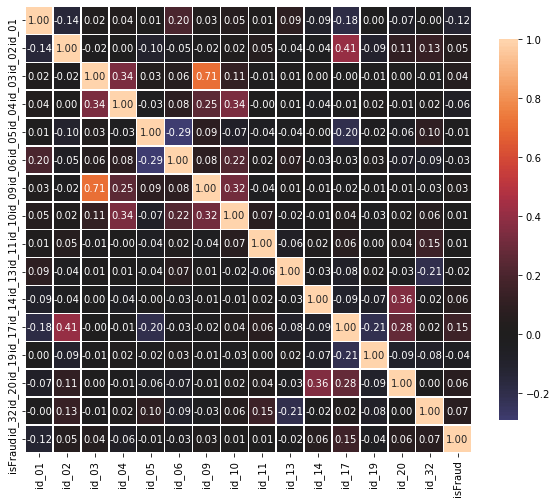

In [14]:
draw_correlation_heatmap(dataframe)

- no correlation coefficient above 0.90; should be fine

## convert object columns to string columns

- np.nan -> 'nan'

In [15]:
for column in dataframe.columns:
    if dataframe[column].dtype == 'object':
        dataframe[column]= dataframe[column].astype(str)

## imputation

- for numbers, fill with interquartile mean

In [16]:
for column in dataframe.columns:
    if dataframe[column].dtype != 'object':
        dataframe[column] = dataframe[column].fillna(dataframe[column].quantile().mean())

## do label encoding for string values

- so that RFE works later

In [17]:
le = LabelEncoder()

for column in dataframe.columns:
    if dataframe[column].dtype == 'object':
        dataframe[column] = le.fit_transform(dataframe[column])

## reduce memory usage again

- since strings are now encoded as numbers

In [18]:
dataframe = reduce_mem_usage(dataframe)

Mem. usage decreased to  8.12 Mb (63.4% reduction)


## separate data into features and target variable

In [19]:
id_features_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

## define function for doing RFECV

- Recursive Feature Elimination with Cross Validation

In [20]:
def do_rfecv(features_dataframe, target_variable, classifier, verbose=True):
    """
    Do Recursive Feature Elimination with Cross Validation.
    Scoring method: ROC AUC

    params:
    - features_dataframe: dataframe that contain features only
    - target_variable: series that contain the target variable
    - classifier: classifier for evaluating feature importance
    - verbose (bool): if True, prints info

    return:
    - rfecv
    """
    rfecv = RFECV(classifier, scoring='roc_auc', n_jobs=2)
    rfecv = rfecv.fit(features_dataframe, target_variable)

    if verbose:
        print(f'Optimal number of features: {rfecv.n_features_}')
        print(f'ROC AUC: {rfecv.grid_scores_[rfecv.n_features_ - 1]}')

    return rfecv

## do Recursive Feature Elimination with Cross Validation (RFECV)

- to select most important features
- using random forest

In [21]:
%%time

rf_classifier = RandomForestClassifier(n_jobs=2)
rfecv = do_rfecv(id_features_dataframe, is_fraud_data, rf_classifier)

Optimal number of features: 14
ROC AUC: 0.7311558448339774
CPU times: user 6min 12s, sys: 1.16 s, total: 6min 14s
Wall time: 16min 46s


## define function to plot accuracy vs number of features

In [22]:
def plot_acc_vs_num_features(grid_scores, method_used):
    plt.figure(figsize=(16, 9))
    plt.title(method_used, fontsize=18, fontweight='bold', pad=20)

    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

    plt.plot(
        range(1, len(grid_scores) + 1), 
        grid_scores, 
        color='#303F9F', 
        linewidth=3,
    )

    plt.show()

## plot line chart of accuracy vs number of features

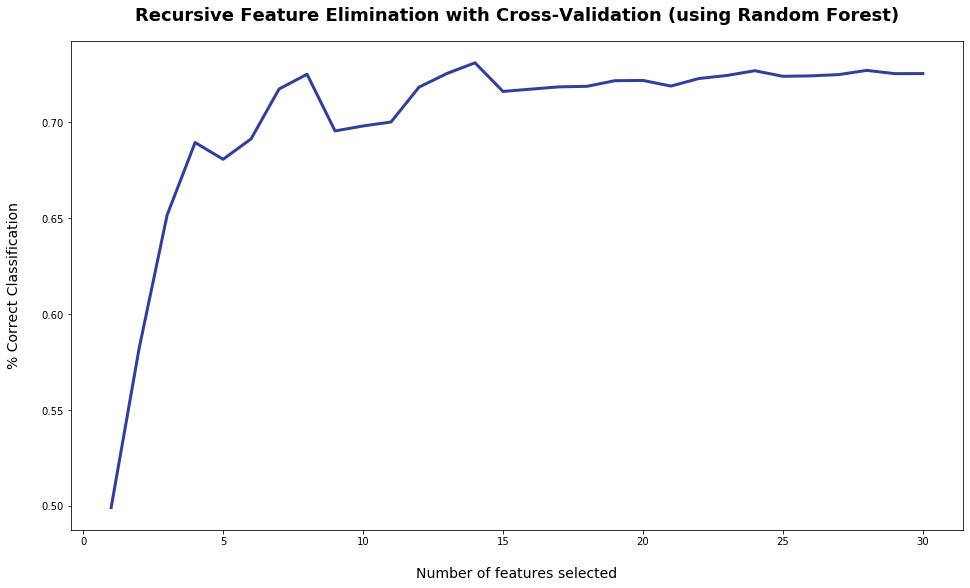

In [23]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Random Forest)', 
)

## show feature ranking

In [24]:
for column, rank in zip(id_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: id_01 rank: 1
feature: id_02 rank: 1
feature: id_03 rank: 6
feature: id_04 rank: 14
feature: id_05 rank: 1
feature: id_06 rank: 1
feature: id_09 rank: 1
feature: id_10 rank: 16
feature: id_11 rank: 10
feature: id_12 rank: 9
feature: id_13 rank: 1
feature: id_14 rank: 2
feature: id_15 rank: 7
feature: id_16 rank: 1
feature: id_17 rank: 1
feature: id_19 rank: 1
feature: id_20 rank: 1
feature: id_28 rank: 13
feature: id_29 rank: 4
feature: id_30 rank: 1
feature: id_31 rank: 1
feature: id_32 rank: 15
feature: id_33 rank: 1
feature: id_34 rank: 8
feature: id_35 rank: 11
feature: id_36 rank: 17
feature: id_37 rank: 12
feature: id_38 rank: 3
feature: DeviceType rank: 5
feature: DeviceInfo rank: 1


## define function to get only the most important features

In [25]:
def get_important_features(features_dataframe, rfecv, verbose=True):
    least_important_features = np.where(rfecv.support_ == False)[0]

    if verbose:
        print('not-important features:', list(features_dataframe.columns[least_important_features]))

    important_features_dataframe = features_dataframe.drop(
        features_dataframe.columns[least_important_features], 
        axis=1
    )

    if verbose:
        print('important features:', list(important_features_dataframe.columns))

    return important_features_dataframe

## keep only the most important features

In [26]:
most_important_features = get_important_features(id_features_dataframe, rfecv)

not-important features: ['id_03', 'id_04', 'id_10', 'id_11', 'id_12', 'id_14', 'id_15', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
important features: ['id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_13', 'id_16', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33', 'DeviceInfo']


## define function to plot feature importance bar chart

In [27]:
def plot_feature_importance_chart(important_features_dataframe, rfecv):
    plot_dataframe = pd.DataFrame()

    plot_dataframe['attr'] = important_features_dataframe.columns
    plot_dataframe['importance'] = rfecv.estimator_.feature_importances_

    plot_dataframe = plot_dataframe.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16, 14))
    plt.barh(
        y=plot_dataframe['attr'], 
        width=plot_dataframe['importance'], 
        color='#1976D2',
    )

    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)

    plt.show()

## plot bar chart for feature importance

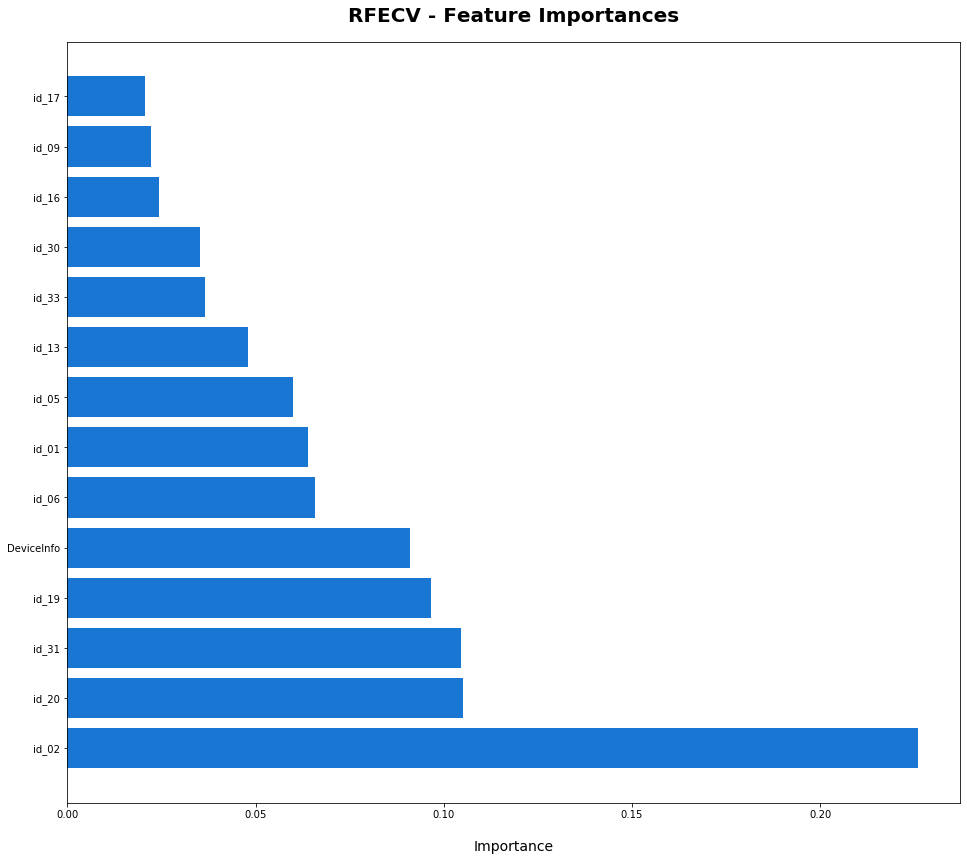

In [28]:
plot_feature_importance_chart(most_important_features, rfecv)

## do RFECV again

- to select most important features
- using light gradient boosting model

In [29]:
%%time

lgbm_classifier = LGBMClassifier()
rfecv = do_rfecv(id_features_dataframe, is_fraud_data, lgbm_classifier)

Optimal number of features: 25
ROC AUC: 0.7269907354678165
CPU times: user 1min 25s, sys: 1.02 s, total: 1min 26s
Wall time: 1min 26s


## plot line chart of accuracy vs number of features

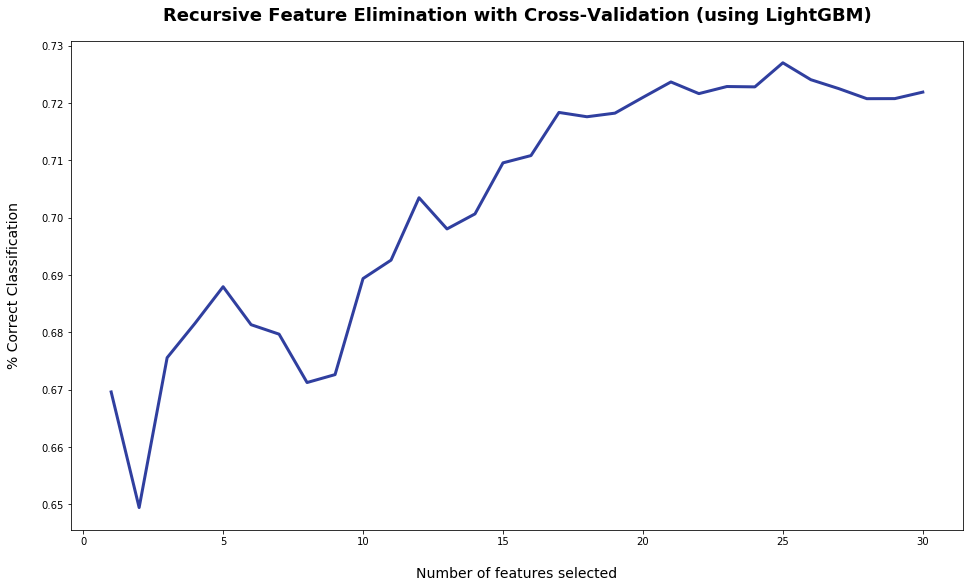

In [30]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using LightGBM)', 
)

## show feature ranking

In [31]:
for column, rank in zip(id_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: id_01 rank: 1
feature: id_02 rank: 1
feature: id_03 rank: 1
feature: id_04 rank: 1
feature: id_05 rank: 1
feature: id_06 rank: 1
feature: id_09 rank: 1
feature: id_10 rank: 1
feature: id_11 rank: 1
feature: id_12 rank: 1
feature: id_13 rank: 1
feature: id_14 rank: 1
feature: id_15 rank: 1
feature: id_16 rank: 4
feature: id_17 rank: 1
feature: id_19 rank: 1
feature: id_20 rank: 1
feature: id_28 rank: 5
feature: id_29 rank: 1
feature: id_30 rank: 1
feature: id_31 rank: 1
feature: id_32 rank: 1
feature: id_33 rank: 1
feature: id_34 rank: 1
feature: id_35 rank: 6
feature: id_36 rank: 3
feature: id_37 rank: 2
feature: id_38 rank: 1
feature: DeviceType rank: 1
feature: DeviceInfo rank: 1


## keep only the most important features

In [32]:
most_important_features = get_important_features(id_features_dataframe, rfecv)

not-important features: ['id_16', 'id_28', 'id_35', 'id_36', 'id_37']
important features: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_38', 'DeviceType', 'DeviceInfo']


## plot bar chart for feature importance

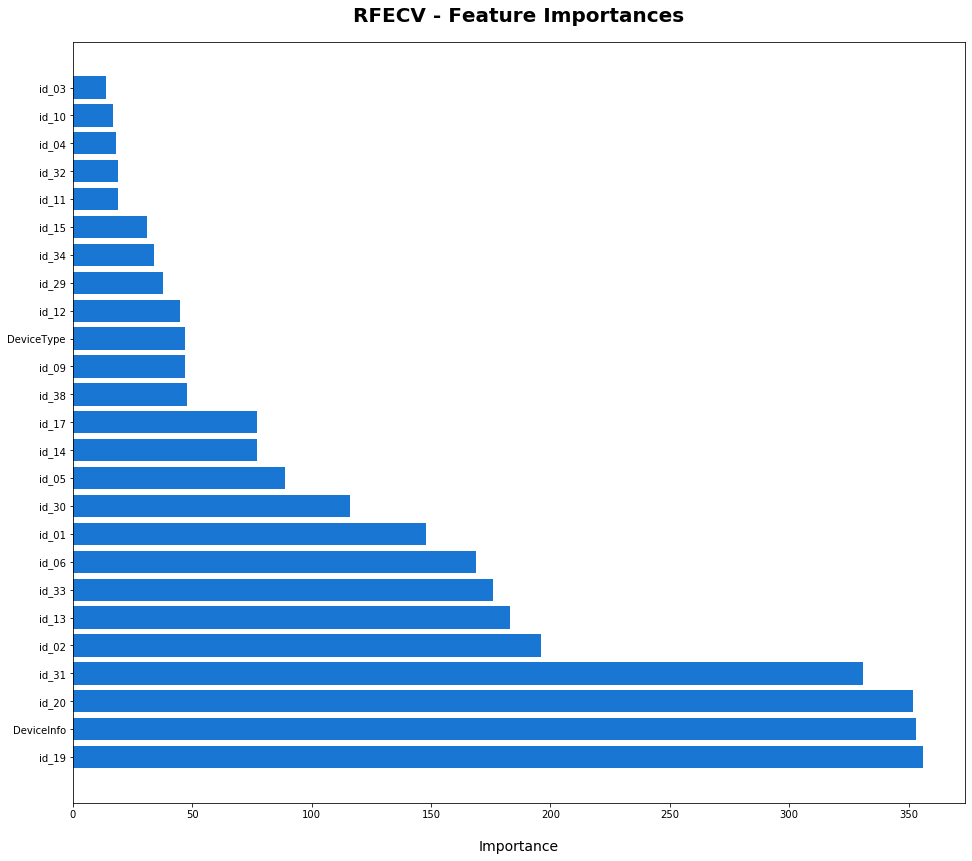

In [33]:
plot_feature_importance_chart(most_important_features, rfecv)

## grouping different OS versions and browsers may be a good idea

In [34]:
# do standard stuff like dropping columns with too many NaNs and reducing memory usage
dataframe = identity_dataframe.merge(is_fraud_dataframe, on='TransactionID')
dataframe = dataframe.drop('TransactionID', axis=1)
dataframe = dataframe.loc[:, dataframe.isna().mean() < 0.6]
dataframe = reduce_mem_usage(dataframe)

dataframe.head()

Mem. usage decreased to 22.15 Mb (37.1% reduction)


,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0
1,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,100.0,NotFound,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,0
3,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,100.0,NotFound,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,0
4,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,0


## list operating systems

In [35]:
print(dataframe.id_30.unique())

['Android 7.0' 'iOS 11.1.2' nan 'Mac OS X 10_11_6' 'Windows 10' 'Android'
 'Linux' 'iOS 11.0.3' 'Mac OS X 10_7_5' 'Mac OS X 10_12_6'
 'Mac OS X 10_13_1' 'iOS 11.1.0' 'Mac OS X 10_9_5' 'Windows 7'
 'Windows 8.1' 'Mac' 'iOS 10.3.3' 'Mac OS X 10.12' 'Mac OS X 10_10_5'
 'Mac OS X 10_11_5' 'iOS 9.3.5' 'Android 5.1.1' 'Android 7.1.1'
 'Android 6.0' 'iOS 10.3.1' 'Mac OS X 10.9' 'iOS 11.1.1' 'Windows Vista'
 'iOS 10.3.2' 'iOS 11.0.2' 'Mac OS X 10.11' 'Android 8.0.0' 'iOS 10.2.0'
 'iOS 10.2.1' 'iOS 11.0.0' 'Mac OS X 10.10' 'Mac OS X 10_12_3'
 'Mac OS X 10_12' 'Android 6.0.1' 'iOS' 'Mac OS X 10.13'
 'Mac OS X 10_12_5' 'Mac OS X 10_8_5' 'iOS 11.0.1' 'iOS 10.0.2'
 'Android 5.0.2' 'Windows XP' 'iOS 11.2.0' 'Mac OS X 10.6' 'Windows 8'
 'Mac OS X 10_6_8' 'Mac OS X 10_11_4' 'Mac OS X 10_12_1' 'iOS 10.1.1'
 'Mac OS X 10_11_3' 'Mac OS X 10_12_4' 'Mac OS X 10_13_2' 'Android 4.4.2'
 'Mac OS X 10_12_2' 'Android 5.0' 'func' 'Android 7.1.2' 'Android 8.1.0'
 'other' 'Mac OS X 10_13_3' 'iOS 11.2.1' 'iOS 11.2.5

## replace to get

- Android
- iOS
- Mac OS X
- Windows
- other

In [36]:
for index, operating_system in dataframe.id_30.iteritems():
    if not isinstance(operating_system, str):
        operating_system = 'other'

    elif 'Android' in operating_system:
        operating_system = 'Android'
    
    elif 'iOS' in operating_system:
        operating_system = 'iOS'

    elif 'Mac OS X' in operating_system:
        operating_system = 'Mac OS X'

    elif 'Windows' in operating_system:
        operating_system = 'Windows'

    else:
        operating_system = 'other'

    dataframe.at[index, 'id_30'] = operating_system

print(dataframe.id_30.unique())

['Android' 'iOS' 'other' 'Mac OS X' 'Windows']


## list browsers

In [37]:
print(dataframe.id_31.unique())

['samsung browser 6.2' 'mobile safari 11.0' 'chrome 62.0' nan
 'chrome 62.0 for android' 'edge 15.0' 'mobile safari generic'
 'chrome 49.0' 'chrome 61.0' 'edge 16.0' 'safari generic' 'edge 14.0'
 'chrome 56.0 for android' 'firefox 57.0' 'chrome 54.0 for android'
 'mobile safari uiwebview' 'chrome' 'chrome 62.0 for ios' 'firefox'
 'chrome 60.0 for android' 'mobile safari 10.0' 'chrome 61.0 for android'
 'ie 11.0 for desktop' 'ie 11.0 for tablet' 'mobile safari 9.0'
 'chrome generic' 'other' 'chrome 59.0 for android' 'firefox 56.0'
 'android webview 4.0' 'chrome 55.0' 'opera 49.0' 'ie'
 'chrome 55.0 for android' 'firefox 52.0' 'chrome 57.0 for android'
 'chrome 56.0' 'chrome 46.0 for android' 'chrome 58.0' 'firefox 48.0'
 'chrome 59.0' 'samsung browser 4.0' 'edge 13.0' 'chrome 53.0 for android'
 'chrome 58.0 for android' 'chrome 60.0' 'mobile safari 8.0'
 'firefox generic' 'Generic/Android 7.0' 'mobile' 'Samsung/SM-G532M'
 'chrome 50.0 for android' 'chrome 51.0 for android' 'chrome 63.0'

## replace with legitimate browsers

In [38]:
browser_list = [
    'aol',
    'chrome',
    'chromium',
    'comodo',
    'cyberfox',
    'edge',
    'firefox',
    'icedragon',
    'ie',
    'iron',
    'maxthon',
    'opera',
    'palemoon',
    'puffin',
    'safari',
    'samsung',
    'seamonkey',
    'silk',
    'waterfox',
]

for index, browser in dataframe.id_31.iteritems():
    new_browser = 'other'

    if isinstance(browser, str):
        for known_browser in browser_list:
            if known_browser in browser:
                new_browser = known_browser
                break

    dataframe.at[index, 'id_31'] = new_browser

print(dataframe.id_31.unique())

['samsung' 'safari' 'chrome' 'other' 'edge' 'firefox' 'ie' 'opera' 'aol'
 'silk' 'waterfox' 'puffin' 'cyberfox' 'palemoon' 'maxthon' 'iron'
 'seamonkey' 'comodo' 'chromium' 'icedragon']


## preprocessing for RFECV

- imputation
- convert mixed-type to string
- encoding
- reduce memory usage

In [39]:
for column in dataframe.columns:
    if dataframe[column].dtype == 'object':
        dataframe[column]= dataframe[column].astype(str)
        dataframe[column] = le.fit_transform(dataframe[column])
    else:
        dataframe[column] = dataframe[column].fillna(dataframe[column].quantile().mean())

dataframe = reduce_mem_usage(dataframe)

Mem. usage decreased to 12.98 Mb (52.2% reduction)


## separate data into features and target variable

In [40]:
id_features_dataframe = dataframe.drop('isFraud', axis=1)
is_fraud_data = dataframe['isFraud']

## do RFECV

- to select most important features
- using random forest

In [41]:
%%time

rf_classifier = RandomForestClassifier(n_jobs=2)
rfecv = do_rfecv(id_features_dataframe, is_fraud_data, rf_classifier)

Optimal number of features: 14
ROC AUC: 0.7407468744377279
CPU times: user 5min 52s, sys: 1.23 s, total: 5min 53s
Wall time: 16min 4s


## plot line chart of accuracy vs number of features

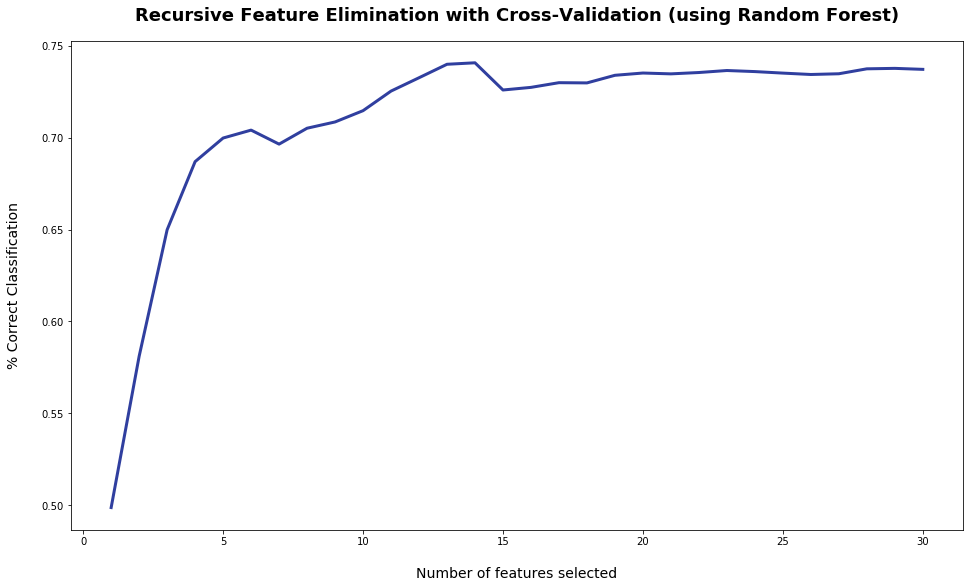

In [42]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Random Forest)', 
)

## show feature ranking

In [43]:
for column, rank in zip(id_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: id_01 rank: 1
feature: id_02 rank: 1
feature: id_03 rank: 6
feature: id_04 rank: 14
feature: id_05 rank: 1
feature: id_06 rank: 1
feature: id_09 rank: 1
feature: id_10 rank: 16
feature: id_11 rank: 10
feature: id_12 rank: 9
feature: id_13 rank: 1
feature: id_14 rank: 1
feature: id_15 rank: 8
feature: id_16 rank: 1
feature: id_17 rank: 1
feature: id_19 rank: 1
feature: id_20 rank: 1
feature: id_28 rank: 13
feature: id_29 rank: 3
feature: id_30 rank: 7
feature: id_31 rank: 1
feature: id_32 rank: 15
feature: id_33 rank: 1
feature: id_34 rank: 4
feature: id_35 rank: 12
feature: id_36 rank: 17
feature: id_37 rank: 11
feature: id_38 rank: 2
feature: DeviceType rank: 5
feature: DeviceInfo rank: 1


## keep only the most important features

In [44]:
most_important_features = get_important_features(id_features_dataframe, rfecv)

not-important features: ['id_03', 'id_04', 'id_10', 'id_11', 'id_12', 'id_15', 'id_28', 'id_29', 'id_30', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
important features: ['id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_13', 'id_14', 'id_16', 'id_17', 'id_19', 'id_20', 'id_31', 'id_33', 'DeviceInfo']


## plot bar chart for feature importance

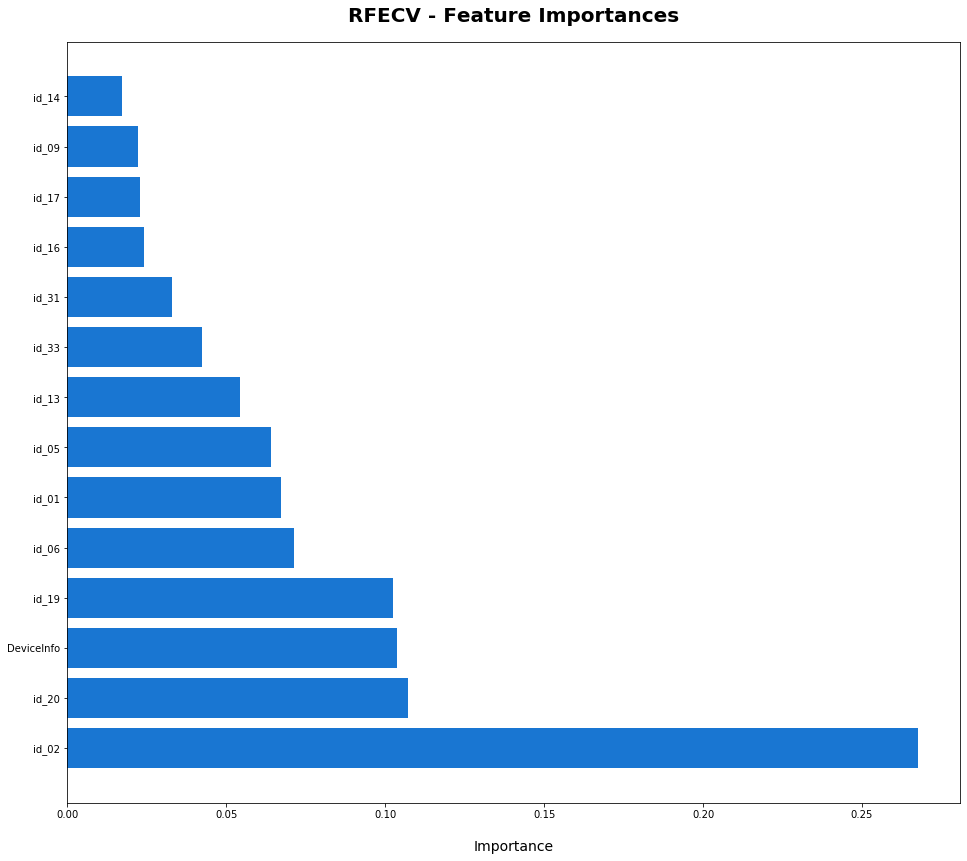

In [45]:
plot_feature_importance_chart(most_important_features, rfecv)

## do RFECV again

- to select most important features
- using light gradient boosting model

In [46]:
%%time

lgbm_classifier = LGBMClassifier()
rfecv = do_rfecv(id_features_dataframe, is_fraud_data, lgbm_classifier)

Optimal number of features: 28
ROC AUC: 0.7479185044746461
CPU times: user 43.6 s, sys: 568 ms, total: 44.2 s
Wall time: 1min 14s


## plot line chart of accuracy vs number of features

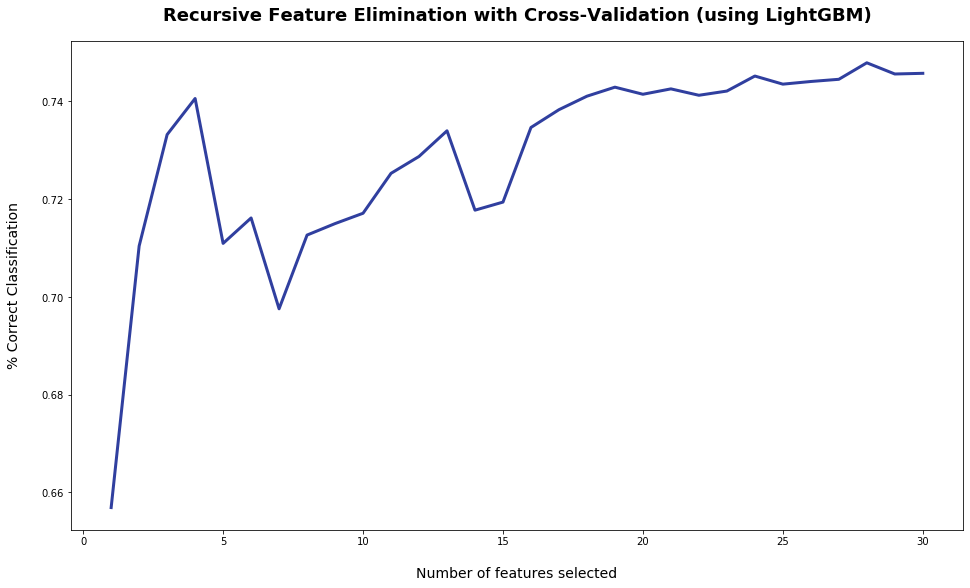

In [47]:
plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using LightGBM)', 
)

## show feature ranking

In [48]:
for column, rank in zip(id_features_dataframe.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')

feature: id_01 rank: 1
feature: id_02 rank: 1
feature: id_03 rank: 1
feature: id_04 rank: 1
feature: id_05 rank: 1
feature: id_06 rank: 1
feature: id_09 rank: 1
feature: id_10 rank: 1
feature: id_11 rank: 1
feature: id_12 rank: 1
feature: id_13 rank: 1
feature: id_14 rank: 1
feature: id_15 rank: 1
feature: id_16 rank: 1
feature: id_17 rank: 1
feature: id_19 rank: 1
feature: id_20 rank: 1
feature: id_28 rank: 3
feature: id_29 rank: 1
feature: id_30 rank: 1
feature: id_31 rank: 1
feature: id_32 rank: 1
feature: id_33 rank: 1
feature: id_34 rank: 1
feature: id_35 rank: 2
feature: id_36 rank: 1
feature: id_37 rank: 1
feature: id_38 rank: 1
feature: DeviceType rank: 1
feature: DeviceInfo rank: 1


## keep only the most important features

In [49]:
most_important_features = get_important_features(id_features_dataframe, rfecv)

not-important features: ['id_28', 'id_35']
important features: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


## plot bar chart for feature importance

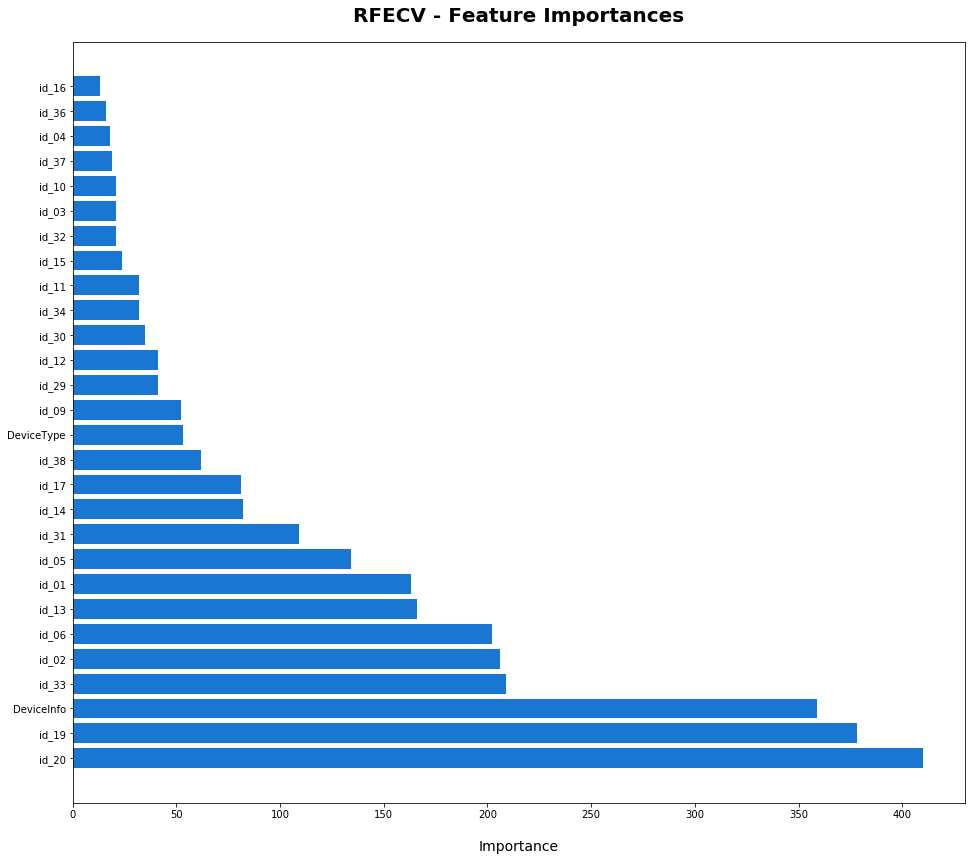

In [50]:
plot_feature_importance_chart(most_important_features, rfecv)

## Result

### without grouping os and browsers by name

using Random Forest

- Optimal number of features: 14
- ROC AUC: 0.7311558448339774
- not-important features: 'id_03', 'id_04', 'id_10', 'id_11', 'id_12', 'id_14', 'id_15', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType'
- important features: 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_13', 'id_16', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33', 'DeviceInfo'

using LightGBM

- Optimal number of features: 25
- ROC AUC: 0.7269907354678165
- not-important features: 'id_16', 'id_28', 'id_35', 'id_36', 'id_37'
- important features: 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_38', 'DeviceType', 'DeviceInfo'

### group os and browsers by name (disregard version number)

using Random Forest

- Optimal number of features: 14
- ROC AUC: 0.7407468744377279
- not-important features: 'id_03', 'id_04', 'id_10', 'id_11', 'id_12', 'id_15', 'id_28', 'id_29', 'id_30', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType'
- important features: 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_13', 'id_14', 'id_16', 'id_17', 'id_19', 'id_20', 'id_31', 'id_33', 'DeviceInfo'

using LightGBM

- Optimal number of features: 28
- ROC AUC: 0.7479185044746461
- not-important features: 'id_28', 'id_35'
- important features: 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'